In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tracker.satellite import Satellite
from tracker.tle import TLE

In [3]:
zarya_tle_archive = None
archive_path = 'tle_files/zarya_2001-2018_tles.txt'

with open(archive_path, 'r') as f_archive:
    zarya_tle_archive = f_archive.read()
    
tle_lines = zarya_tle_archive.split('\n')[:-1]
tles = []

for i in range(0, len(tle_lines), 2):
    line1, line2 = tle_lines[i:i + 2]
    tle = TLE(line1, line2)
    tles.append(tle)

In [4]:
tles.sort(key=attrgetter('epoch'))
type(tles[0])

tracker.tle.TLE

In [5]:
def two_tle_error(tle1, tle2):
    OBS_LAT = -15.989620
    OBS_LON = -48.044411
    OBS_ALT = 500 # meters
    
    sat1 = Satellite(*tle1.tle)
    sat2 = Satellite(*tle2.tle)
    
    epoch1 = tle1.epoch
    epoch2 = tle2.epoch
    
    az1, el1 = sat1.get_observer_azimuth_elevation(OBS_LAT, OBS_LON, OBS_ALT, date=epoch2)
    az2, el2 = sat2.get_observer_azimuth_elevation(OBS_LAT, OBS_LON, OBS_ALT, date=epoch2)
    
    return abs(az1 - az2), abs(el1 - el2), epoch2 - epoch1

In [6]:
tle1 = tles[0]
tle2 = tles[1]

print(tle1.tle)

('1 25544U 98067A   17001.10660880  .00001073  00000-0  23630-4 0  9997', '2 25544  51.6423 151.2131 0007045  39.8224 315.5565 15.53964187 35761')


In [7]:
errors = [two_tle_error(tles[i - 1], tles[i]) for i in range(1, len(tles))]
az_errors = np.array([err[0] for err in errors])
el_errors = np.array([err[1] for err in errors])
date_delta_hours = np.array([err[2].total_seconds() / 3600.0 for err in errors])

In [8]:
error_table = pd.DataFrame(
    {'Azimuth error (degrees)': az_errors,
     'Elevation error (degrees)': el_errors,
     'Date delta (hours)': date_delta_hours})

display(error_table.head())

,Azimuth error (degrees),Elevation error (degrees),Date delta (hours)
0,0.000226,0.000076,1.484166
1,0.001001,0.000265,9.791784
2,0.000000,0.000000,0.000000
3,0.000639,0.000515,3.198929
4,0.003873,0.000846,7.614045


# Estatísticas dos erros e tempo de diferença entre TLE consecutivos

In [9]:
error_table.describe()

,Azimuth error (degrees),Elevation error (degrees),Date delta (hours)
count,2868.000000,2868.000000,2868.000000
mean,0.005727,0.003113,5.521666
std,0.042440,0.021275,5.752167
min,0.000000,0.000000,0.000000
25%,0.000088,0.000065,1.581811
50%,0.000752,0.000405,4.474303
75%,0.002614,0.001471,7.279420
max,1.332285,0.532718,52.952656


# Plotando os erros

In [10]:
def plot_arr(arr, title, xlabel='Error'):
    fig, ax = plt.subplots(1, 1, dpi=100)
    plt.hist(arr, alpha = 0.5, lw=1, color= 'b', edgecolor='k')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title(title)
    plt.ylabel('Number of ocorrencies')
    plt.xlabel(xlabel)
    plt.show()

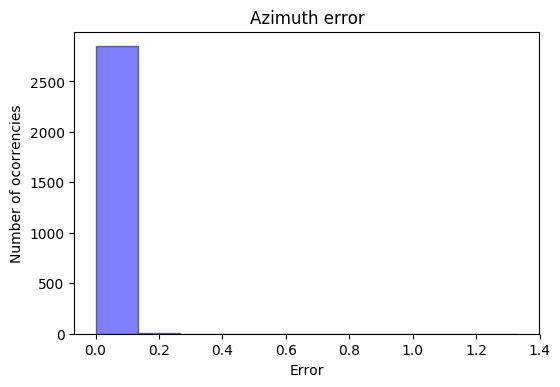

In [11]:
plot_arr(az_errors, 'Azimuth error')

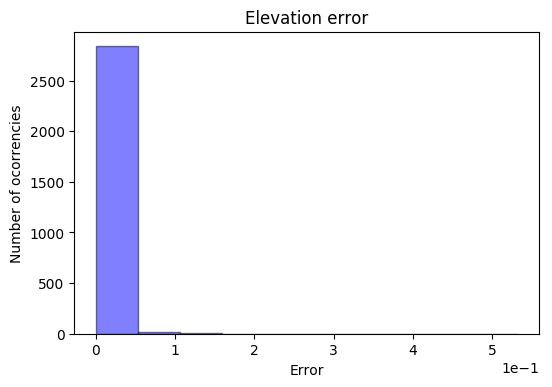

In [12]:
plot_arr(el_errors, 'Elevation error')

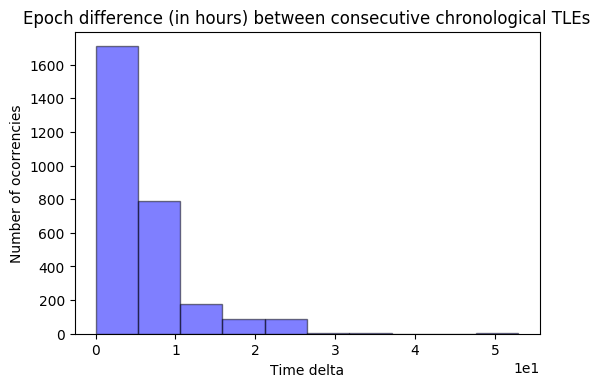

In [13]:
plot_arr(date_delta_hours, 'Epoch difference (in hours) between consecutive chronological TLEs', 'Time delta')

# Calculando erro do TLE em relação a atrasos de TLE

Por exemplo, se estamos considerando um atraso de 3 TLES, então definimos step=3. Caso estejamos interessados num atraso de 15 TLES, então definimos step=15. O erro que estamos interessados é a média dos erros absolutos dos parâmetros azimute e elevação.

In [14]:
def find_delayed_pairs(tles, step):
    az = []
    el = []
    for i in range(step, len(tles)):
        j = i - step
        tle1 = tles[i]
        tle2 = tles[j]
        errors = two_tle_error(tle1, tle2)
        time_delta = errors[2].total_seconds()
        az.append(errors[0])
        el.append(errors[1])
        
    
    assert len(az) == len(el)            
    return az, el

In [15]:
data = dict()

mean_std = lambda x: (np.mean(x), np.std(x))

steps = [1, 5, 15, 50]

for i in steps:
    az, el = find_delayed_pairs(tles, i)
    data['Azimuth errors (step={})'.format(i)] = mean_std(az)
    data['Elevation errors (step={})'.format(i)] = mean_std(el)

df = pd.DataFrame(data, index=['mean', 'std'])
display(df.head())

,Azimuth errors (step=1),Elevation errors (step=1),Azimuth errors (step=5),Elevation errors (step=5),Azimuth errors (step=15),Elevation errors (step=15),Azimuth errors (step=50),Elevation errors (step=50)
mean,0.002624,0.001470,0.029502,0.018355,0.720717,0.148959,7.640852,1.292093
std,0.017478,0.011765,0.396749,0.292796,13.080121,1.027914,43.528157,4.408910
